# Scatter JND Example Study

In this example, we'll create a full Scatter JND study using vega components. We'll use numpy and scipy to generate a dataset, pandas to create a well-structured data frame, and the `revisitpy` package to tie it all together.

You'll see that we have a section which uses the `revisitpy` Widget. This widget is a fully interactive jupyter notebook widget which allows us to preview the created study directly in the notebook. You'll notice that we also utilize the `revisitpy_server` package. This is to simplify the process of viewing our widget. Specifically, it removes the requirement of having a version of the reVISit repository running locally on your computer.


We'll start by defining the basic structure of the study:

In [1]:

import revisitpy as rvt

# Meta Data
study_metadata = rvt.studyMetadata(
    authors=["Brian Bollen"],
    organizations=["Visualization Design La"],
    title='Showcasing revisit-py',
    description='',
    date='2025-01-13',
    version='1.0'
)


# UI Config
ui_config = rvt.uiConfig(
  contactEmail="briancbollen@gmail.com",
  logoPath="./assets/revisitLogoSquare.svg",
  sidebar=True,
  withProgressBar=False
)

# Introduction
introduction = rvt.component(type='markdown', path='./assets/introduction.md', component_name__= 'introduction')

# Snippet of the introduction component.
print(introduction)


{
    "path": "./assets/introduction.md",
    "response": [],
    "type": "markdown"
}


## Generating the Data

We now want to generate the datasets that will go into our vega charts. We don't yet have to worry about rendering these, we'll just define the functions to generate the data.

In [2]:
import numpy as np
from scipy.special import erfinv, erf

def generate_correlated_data_uniform(correlation, num_points, seed=None):
    """
    Generate a dataset with two variables having the specified correlation,
    with values bounded between 0 and 1.
    Parameters:
        correlation (float): Desired correlation coefficient (-1 to 1).
        num_points (int): Number of data points to generate.
        seed (int, optional): Random seed for reproducibility.
    Returns:
        np.ndarray: A 2D array of shape (num_points, 2), where each column is a variable.
    """
    if not -1 <= correlation <= 1:
        raise ValueError("Correlation must be between -1 and 1.")
    if seed is not None:
        np.random.seed(seed)
    # Generate two independent uniform random variables between 0 and 1
    x = np.random.rand(num_points)
    z = np.random.rand(num_points)
    # Apply inverse transform sampling to convert uniform to normal
    x_normal = np.sqrt(2) * erfinv(2 * x - 1)  # Inverse CDF of normal distribution
    z_normal = np.sqrt(2) * erfinv(2 * z - 1)
    # Combine them using the desired correlation
    y_normal = correlation * x_normal + np.sqrt(1 - correlation**2) * z_normal
    # Transform back to uniform distribution using normal CDF
    x_uniform = 0.5 * (1 + erf(x_normal / np.sqrt(2)))
    y_uniform = 0.5 * (1 + erf(y_normal / np.sqrt(2)))
    # Stack into a 2D array
    data = np.column_stack((x_uniform, y_uniform))
    return data

# Example of dataset
print(generate_correlated_data_uniform(0.6, 10, seed=42))

[[0.37454012 0.03397256]
 [0.95071431 0.99369625]
 [0.73199394 0.87335673]
 [0.59865848 0.31251313]
 [0.15601864 0.09121347]
 [0.15599452 0.09198872]
 [0.05808361 0.08811887]
 [0.86617615 0.76262552]
 [0.60111501 0.50662253]
 [0.70807258 0.45573666]]


# Vega Altair Chart

Let's create vega altair chart with two scatterplots. We start with two data frames `data1` and `data2`, each with `x` and `y` columns. We then create two scatterplots for those data and concat them to place them side-by-side. The generated vega-spec will be imported to reVISit config.

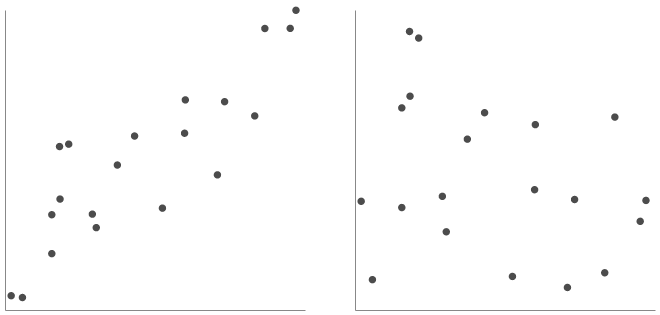

In [3]:
import random
import pandas as pd
import altair as alt
import vl_convert as vlc

# Enable png output to save the image.
alt.renderers.enable("png")

def create_vega_chart(visType, numPoints, corrValues):
    random.shuffle(corrValues)
    # Convert NumPy array to a DataFrame
    data1 = pd.DataFrame(
        generate_correlated_data_uniform(corrValues[0], numPoints, seed=42),
        columns=['X', 'Y']
    )
    data2 = pd.DataFrame(
        generate_correlated_data_uniform(corrValues[1], numPoints, seed=42),
        columns=['X', 'Y']
    )
    
    # Create Scatter plot 1
    scatter1 = alt.Chart(data1).mark_point(fill='black', stroke='black').encode(
        x=alt.X('X:Q', axis=alt.Axis(
            labels=False,
            ticks=False,
            grid=False,
            domain=True,
            title=None

        )),
        y=alt.Y('Y:Q', axis=alt.Axis(
            labels=False,
            ticks=False,
            grid=False,
            domain=True,
            title=None
        ))
    ).properties(
        title='',
        width=300,
        height=300,
    )
    
    # Create Scatter plot two
    scatter2 = alt.Chart(data2).mark_point(fill='black', stroke='black').encode(
        x=alt.X('X:Q', axis=alt.Axis(
            labels=False,
            ticks=False,
            grid=False,
            domain=True,
            title=None

        )),
        y=alt.Y('Y:Q', axis=alt.Axis(
            labels=False,
            ticks=False,
            grid=False,
            domain=True,
            title=None
        ))
    ).properties(
        title='',
        width=300,
        height=300
    )

    # Horizontally concatenate the plots
    chart = alt.hconcat(
        scatter1,
        scatter2
    ).configure_view(
        strokeWidth=0,  
        continuousWidth=300,  
        continuousHeight=300, 
        step=50               
    ).configure_concat(
        spacing=50  
    )

    vega_lite_spec = chart.to_json()
    vega_spec = vlc.vegalite_to_vega(vega_lite_spec, vl_version="5.20")
    return [vega_spec, chart]

[my_vega_spec, my_chart] = create_vega_chart('scatterPlot', 20, [0.3,0.9])

# Display Chart
my_chart




# Creating The Component Function

In order to permute and create these charts based on these variables, we define a component function to be passed into our permutation method. When we permute over the factors, we use this component function to generate the final component.

In [4]:
def component_function(visType=None, numPoints=None, corrValues=None):
    if(visType is not None and numPoints is not None and corrValues is not None):
        [vega_spec, chart] = create_vega_chart(visType=visType, numPoints=numPoints, corrValues=corrValues)
            
        # Update signals with new signals for the final vega spec.
        vega_spec['config']["signals"] = [
            {
                "name": "revisitAnswer",
                "value": {},
                "on": [
                    {
                        "events": "@concat_0_group:click",
                        "update": "{responseId: 'vegaDemoResponse1', response: 'left'}"
                    },
                    {
                        "events": "@concat_1_group:click",
                        "update": "{responseId: 'vegaDemoResponse1', response: 'right'}"
                    },
                    {
                        "events": {"source": "window", "type": "keydown"},
                        "update": "event.key === 'ArrowLeft' ? {responseId: 'vegaDemoResponse1', response: 'left'} : event.key === 'ArrowRight' ? {responseId: 'vegaDemoResponse1', response: 'right'} : revisitAnswer"
                    },
                ]
            }
        ]
        
        # Add signal based bordering
        for entry in vega_spec['marks']:
            if entry['name'] == 'concat_0_group':
                condition = 'left'
            else:
                condition = 'right'
            entry['encode']['update']['stroke'] = {
                "signal": f"revisitAnswer.response === '{condition}' ? 'blue' : null"
            },
            entry['encode']['update']['strokeWidth'] = {
                "signal": f"revisitAnswer.response === '{condition}' ? 3 : 0"
            }
        
        return rvt.component(
            type='vega',
            config=vega_spec,
            component_name__=f'{visType}-{numPoints}-{round(corrValues[0],1)},{round(corrValues[1],1)}',
            response=[
                rvt.response(
                    id='vegaDemoResponse1',
                    prompt='You Selected: ',
                    location='sidebar',
                    type='iframe',
                    required=True
                )
            ]
        )

    return rvt.component(
        type='questionnaire',
        component_name__='blank-component'
    )

# You can print the output of our component function with some test values.

# print(component_function('scatterPlot',20,corrValues=[0.2,0.9]))

# Final Sequencing

Here we generate the different combinations of the correlation values that we'd like (every combination of two numbers between 0 and 1 with precision 1). Then, we generate a fixed order sequence and being the permutations over our factors. We first permute over the visualization type, then over the number of points, then over all possible correlation value pairs.

Once this sequence is generated, we append it to a sequence only containing the introduction.

In [5]:
import itertools

# Generate all combinations of two values between 1 and 10
combinations = itertools.combinations(range(1, 11), 2)

# Create the dataset with values divided by 10
dataSet = [{'corrValues': [x / 10, y / 10]} for x, y in combinations]
# Create the dataset with values divided by 10


main_sequence = rvt.sequence(order='fixed')

main_sequence.permute(
        factors=[{'visType': 'scatterPlot'}, {'visType': 'parallelCoords'}],
        order='latinSquare',
    ).permute(
        factors=[{'numPoints': 20}, {'numPoints': 100}],
        order='fixed',
    ).permute(
        factors=dataSet,
        order='random',
        component_function=component_function
    )
    
sequence = rvt.sequence(order='fixed',components=[introduction]) + main_sequence

study = rvt.studyConfig(
    schema="https://raw.githubusercontent.com/revisit-studies/study/v2.0.0-rc1/src/parser/StudyConfigSchema.json",
    uiConfig=ui_config,
    studyMetadata=study_metadata,
    sequence=sequence
)

# Prints the entire configuration file which is approximately 150,000 lines of JSON
# print(study)


# Using `revisitpy_server` to Prepare Our Widget

The `revisitpy` package provides a widget in order to preview our study directly in a Jupyter notebook. We can interact with the study, check that vega signals work, and even create some introductory data ourselves. In order for the widget to work, a local copy of the reVISit must be running on your local computer. If you already have reVISit locally (colloqioully our `study` repo), then all you need to do is navigate to your repository and run `yarn serve`. After this, the widget we create in this jupyter notebook will be useable.

A simpler way to achieve the same goal, however is using the `revisitpy_server` Python package. This is a simple python package which already has the most recent reVISit repository built and runs a server locally. After installing `revisitpy_server`, all that is required is the following:

In [6]:
import revisitpy_server as rs
process = rs.serve()

Server is running in the background at http://localhost:8080


# The Widget

Now that your server is running, we create the widget with the configuration file we created above. When calling the widget, we are assuming that the assets referenced in the configuration file are relative to this notebook. The widget then copies these static assets to the appropriate directory. Since we're currently using the `revisitpy_server` package, you'll see that they copied into the assets of the local virtual environment `revisitpy_server` package.

In [7]:
w = rvt.widget(study, server=True)

# In your own Jupyter notebook, calling `w` will now display the widget in a fully interactive manner.
# w

Copying file from ./assets/introduction.md to /Users/bbollen23/revisit-py-examples/.venv/lib/python3.12/site-packages/revisitpy_server/static/__revisit-widget/assets/introduction.md
Copying file from ./assets/revisitLogoSquare.svg to /Users/bbollen23/revisit-py-examples/.venv/lib/python3.12/site-packages/revisitpy_server/static/__revisit-widget/assets/revisitLogoSquare.svg


# Optional: Terminate the server

Closing the notebook will automatically terminate the server. If you'd rather do this manually, you can do the following.

In [21]:
process.terminate()